In [1]:
import jax
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd


import time

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    precision = jnp.linalg.inv(cov)


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [5]:
def gaussian_kernel(x, y, sigma):


    x_norm = jnp.sum(x**2, axis=1).reshape(-1, 1)
    y_norm = jnp.sum(y**2, axis=1).reshape(1, -1)
    sq_dists = x_norm + y_norm - 2 * x @ y.T


    return jnp.exp(-sq_dists / (2 * sigma**2))

def compute_mmd_rbf(samples, evolved_samples, sigma=1.0):


    n = samples.shape[0]
    m = evolved_samples.shape[0]


    K_xx = gaussian_kernel(samples, samples, sigma)
    K_yy = gaussian_kernel(evolved_samples, evolved_samples, sigma)
    K_xy = gaussian_kernel(samples, evolved_samples, sigma)


    mmd = (
        jnp.sum(K_xx) - jnp.trace(K_xx)
    ) / (n * (n - 1)) + (
        jnp.sum(K_yy) - jnp.trace(K_yy)
    ) / (m * (m - 1)) - 2 * jnp.sum(K_xy) / (n * m)


    return mmd


In [6]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return compute_mmd_rbf(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=1,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [8]:
mu = jnp.array([0.0, 1.0, -1.0, 0.5, -0.5])


cov = jnp.array([
    [1.0, 0.4, 0.3, 0.2, 0.1],
    [0.4, 1.0, 0.5, 0.3, 0.2],
    [0.3, 0.5, 1.0, 0.4, 0.3],
    [0.2, 0.3, 0.4, 1.0, 0.5],
    [0.1, 0.2, 0.3, 0.5, 1.0]
])

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


time_start = time.time()


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, base_lr=0.1, seed = 0)


time_end = time.time()
time_elapsed = time_end - time_start
time_round = time_elapsed/800
print(time_round)

epoch 0 | loss = 0.032621
epoch 1 | loss = 0.032213
epoch 2 | loss = 0.031865
epoch 3 | loss = 0.031568
epoch 4 | loss = 0.031310
epoch 5 | loss = 0.031075
epoch 6 | loss = 0.030853
epoch 7 | loss = 0.030638
epoch 8 | loss = 0.030427
epoch 9 | loss = 0.030218
epoch 10 | loss = 0.030011
epoch 11 | loss = 0.029806
epoch 12 | loss = 0.029603
epoch 13 | loss = 0.029399
epoch 14 | loss = 0.029192
epoch 15 | loss = 0.028981
epoch 16 | loss = 0.028763
epoch 17 | loss = 0.028537
epoch 18 | loss = 0.028303
epoch 19 | loss = 0.028058
epoch 20 | loss = 0.027805
epoch 21 | loss = 0.027543
epoch 22 | loss = 0.027273
epoch 23 | loss = 0.026994
epoch 24 | loss = 0.026709
epoch 25 | loss = 0.026417
epoch 26 | loss = 0.026122
epoch 27 | loss = 0.025827
epoch 28 | loss = 0.025535
epoch 29 | loss = 0.025253
epoch 30 | loss = 0.024985
epoch 31 | loss = 0.024738
epoch 32 | loss = 0.024516
epoch 33 | loss = 0.024323
epoch 34 | loss = 0.024158
epoch 35 | loss = 0.024019
epoch 36 | loss = 0.023896
epoch 37 | 

In [10]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[ 0.   1.  -1.   0.5 -0.5] 

 [ 0.0687  1.0063 -0.9239  0.4351 -0.5428] 0.08147763 



[[1.  0.4 0.3 0.2 0.1]
 [0.4 1.  0.5 0.3 0.2]
 [0.3 0.5 1.  0.4 0.3]
 [0.2 0.3 0.4 1.  0.5]
 [0.1 0.2 0.3 0.5 1. ]] 

 [[0.9392 0.3193 0.2611 0.1486 0.0545]
 [0.3193 1.0222 0.5138 0.3135 0.1968]
 [0.2611 0.5138 1.0655 0.4402 0.4414]
 [0.1486 0.3135 0.4402 1.0426 0.5094]
 [0.0545 0.1968 0.4414 0.5094 1.1398]] 0.11626007 





In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

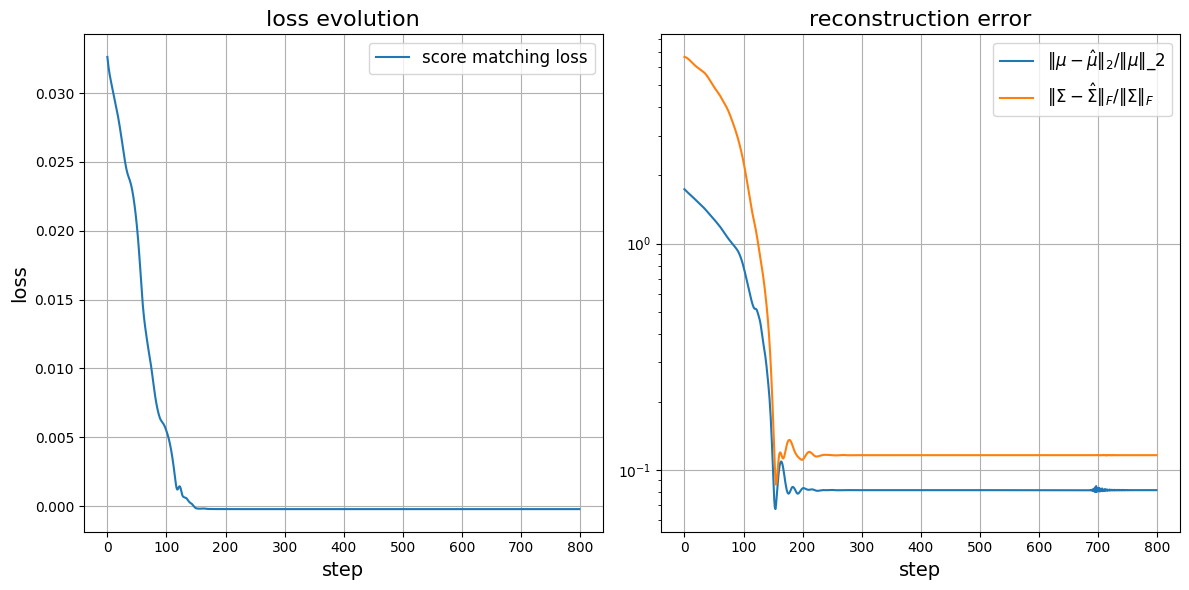

In [12]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [ ]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 0.033824
epoch 1 | loss = 0.032823
epoch 2 | loss = 0.031908
epoch 3 | loss = 0.031065
epoch 4 | loss = 0.030288
epoch 5 | loss = 0.029572
epoch 6 | loss = 0.028909


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


epoch 7 | loss = 0.028290
epoch 8 | loss = 0.027706
epoch 9 | loss = 0.027149
epoch 10 | loss = 0.026613
epoch 11 | loss = 0.026093
epoch 12 | loss = 0.025584
epoch 13 | loss = 0.025081
epoch 14 | loss = 0.024580
epoch 15 | loss = 0.024079
epoch 16 | loss = 0.023575
epoch 17 | loss = 0.023065
epoch 18 | loss = 0.022549
epoch 19 | loss = 0.022023
epoch 20 | loss = 0.021487
epoch 21 | loss = 0.020941
epoch 22 | loss = 0.020385
epoch 23 | loss = 0.019819
epoch 24 | loss = 0.019244
epoch 25 | loss = 0.018665
epoch 26 | loss = 0.018083
epoch 27 | loss = 0.017504
epoch 28 | loss = 0.016935
epoch 29 | loss = 0.016384
epoch 30 | loss = 0.015857
epoch 31 | loss = 0.015364
epoch 32 | loss = 0.014909
epoch 33 | loss = 0.014494
epoch 34 | loss = 0.014116
epoch 35 | loss = 0.013762
epoch 36 | loss = 0.013415
epoch 37 | loss = 0.013051
epoch 38 | loss = 0.012651
epoch 39 | loss = 0.012204
epoch 40 | loss = 0.011713
epoch 41 | loss = 0.011188
epoch 42 | loss = 0.010647
epoch 43 | loss = 0.010103
epoc

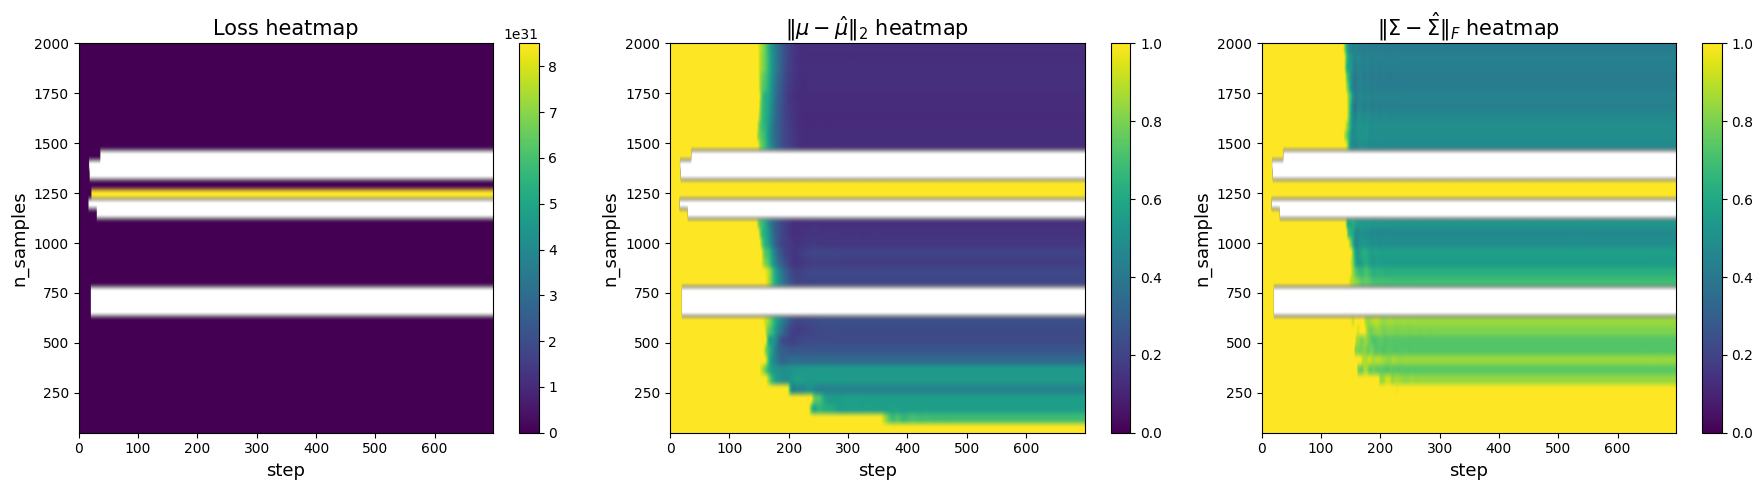

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()